# EEC 174AY Lab B2 

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.text_cell_render p{
    font-size: 130%;
    line-height: 125%;
}
</style>
""")

In [2]:
from pathlib import Path

import copy
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import SGD
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from dataset import PVADataset

from tqdm.auto import tqdm

## Outline

This lab will build your skills in utilizing LSTM networks so that you can apply deep learning to time series information

1. you will code an LSTM network and apply it to a pre-built codebase. Your focus will be on the ML coding
2. You will utilize a partially built code base and then finish it to detect ARDS in waveform data.

## LSTM Network

LSTM is a network that is able to utilize time series information and learn long term patterns to make more accurate predictions than a normal neural network would be able to. We show the general network architecture as an instruction for what you will need to code.

<img src="The_LSTM_cell.png" width=55% height=auto\>

You will be applying LSTM to the task of patient ventilator asynchrony (PVA) detection. We have supplied a bit of the code you will need. Your jobs will be the following:

1. Code the `find_scaling_coefs`, `scale_breath`, and `pad_or_cut_breath` methods in the `PVADataset` class in `dataset.py`.
2. Code a simple 1 layer LSTM network based on network schematics given above. You are welcome to use other resource for assistance as well.
3. Run your LSTM model on PVA detection. How well does your model perform compared to your original Random Forest classifier? Why are you getting these results?
4. Code a more complex 3 layer LSTM network. Do additional layers improve results? Why/Why not?

For the math required we would advise you follow the [PyTorch LSTM mathematics](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) 

Adopted from:

- https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch/blob/main/LICENSE

In [3]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_units, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.bias = bias

        # Create weights fully connected layers for the weights for x and h
        self.xh = nn.Linear(input_size, hidden_units * 4, bias=bias)
        self.hh = nn.Linear(hidden_units, hidden_units * 4, bias=bias)
        self.reset_parameters()

    # Normalize Weights
    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_units)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_units)
        # Outputs:
        #       hy: of shape (batch_size, hidden_units)
        #       cy: of shape (batch_size, hidden_units)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_units))
            hx = (hx, hx)

        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)

        # Get gates (i_t, f_t, g_t, o_t)
        i_t, f_t, g_t, o_t = gates.chunk(4, 1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)
        o_t = torch.sigmoid(o_t)

        forget_gate = (cx * f_t)
        input_gate = (i_t * g_t)

        cy =  forget_gate + input_gate

        output_gate = (o_t * torch.tanh(cy))

        hy = output_gate

        return (hy, cy)


In [4]:
class LSTM(nn.Module):
    '''
        The shape for the input data is (batch_size, seq_length, input_size).
        The shape for the output labels is (batch_size, output_size).
    '''
    def __init__(self, input_size, hidden_units, num_layers, bias, output_size):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.lstm_cell_list = nn.ModuleList()

        self.lstm_cell_list.append(LSTMCell(self.input_size,
                                            self.hidden_units,
                                            self.bias))
        for l in range(1, self.num_layers):
            self.lstm_cell_list.append(LSTMCell(self.hidden_units,
                                                self.hidden_units,
                                                self.bias))

        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def forward(self, input, hx=None):

        # Input of shape (batch_size, seqence length , input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_units).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_units))
        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append((h0[layer, :, :], h0[layer, :, :]))

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.lstm_cell_list[layer](
                        input[:, t, :],
                        (hidden[layer][0],hidden[layer][1])
                        )
                else:
                    hidden_l = self.lstm_cell_list[layer](
                        hidden[layer - 1][0],
                        (hidden[layer][0], hidden[layer][1])
                        )

                hidden[layer] = hidden_l

            outs.append(hidden_l[0])

        out = outs[-1].squeeze()

        out = self.fc(out)

        return out

In [5]:
class LSTMNetwork(nn.Module):
    def __init__(self):
        super(LSTMNetwork, self).__init__()
        # Feel free to modify this
        self.lstm_hidden_units = 32
        # First layer is defined for you. Only have 2 input features (flow, pressure)
        self.xi = nn.Linear(2, self.lstm_hidden_units)
        self.xf = nn.Linear(2, self.lstm_hidden_units)
        self.xo = nn.Linear(2, self.lstm_hidden_units)
        self.xg = nn.Linear(2, self.lstm_hidden_units)

        # 
        self.hi = nn.Linear(self.lstm_hidden_units, self.lstm_hidden_units)
        self.hf = nn.Linear(self.lstm_hidden_units, self.lstm_hidden_units)
        self.ho = nn.Linear(self.lstm_hidden_units, self.lstm_hidden_units)
        self.hg = nn.Linear(self.lstm_hidden_units, self.lstm_hidden_units)

        # Final layer is defined for you too. Have 3 potential output classes (normal, bsa, dta)
        self.final_classification = nn.Linear(self.lstm_hidden_units, 3)
        
    def forward(self, x, hx = None):
        if hx is None:
            hx = Variable(x.new_zeros(x.size(0), x.size(1), self.lstm_hidden_units))
            hx = (hx, hx)

        hx, cx = hx

        print('cx: ', np.shape(cx))

        dummy = self.hi(hx)

        print('dummy: ', np.shape(dummy))
        
        i_t = F.sigmoid(self.xi(x) + dummy)
        f_t = F.sigmoid(self.xf(x) + self.hf(hx))
        o_t = F.sigmoid(self.xo(x) + self.ho(hx))
        g_t = F.tanh(self.xg(x) + self.hg(hx))

        print('i_t: ', np.shape(i_t))

        cx = torch.matmul(cx, f_t) + torch.matmul(i_t, g_t)

        hy = torch.matmul(o_t, F.tanh(cx))

        out = self.final_classification(hy)
        
        return out
    

In [6]:
def verify_coeffs(training_set, validation_set, testing_set):
    print('Verifying cofficients match...')

    # Load Flow Coefficients for Validation and Testing
    flow_mus = [validation_set.flow_mu, testing_set.flow_mu]
    flow_stds = [validation_set.flow_std, testing_set.flow_std]

    # Load Pressure Coefficients for Validation and Testing
    pressure_mus = [validation_set.pressure_mu, testing_set.pressure_mu]
    pressure_stds = [validation_set.pressure_std, testing_set.pressure_std]

    # Check if the Validation and Testing Coefficients match Training Coefficients               
    for idx in range(len(flow_mus)):
        if training_set.flow_mu != flow_mus[idx] or training_set.flow_std != flow_stds[idx] :
            raise Exception('Flow coefficients do not match!')
        elif training_set.pressure_mu != pressure_mus[idx] or training_set.pressure_std != pressure_stds[idx] :
            raise Exception('Pressure coefficients do not match!')
            
    print('Coefficients match!')

In [7]:
history = {
    'model': str,
    'batch_size': int,
    'learning_rate': float,
    'optimizer': str,
    'training_loss': [],
    'validation_loss': [],
    'training_accuracy': [],
    'validation_accuracy': []
}

In [8]:
seq_len = 224

def get_dataset(path, name):
    saved_set = Path(path)
    # Make sure we save previously processed data. This speeds up future processes.
    if saved_set.exists():
        dataset = pd.read_pickle(saved_set.resolve())
    else:
        # use a sequence length of 224 inputs. If you want to shorten this feel free.
        dataset = PVADataset(name, seq_len)
        dataset.process_dataset()
        pd.to_pickle(dataset, saved_set.resolve())
    return dataset

In [9]:
def get_all_datasets():
    print('Loading Training Data')
    training_set = get_dataset('pva_training_set.pkl', 'train')
    print('Loading Validation Data')
    validation_set = get_dataset('pva_validation_set.pkl', 'val')
    print('Loading Testing Data')
    testing_set = get_dataset('pva_testing_set.pkl', 'test')
    return training_set, validation_set, testing_set

In [10]:
batch_size = 16
num_workers = 4

training_set, validation_set, testing_set = get_all_datasets()
# XXX make sure val and testing share same coefficients as training set!!
verify_coeffs(training_set, validation_set, testing_set)

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False, pin_memory=True)
# You can write up the rest of the code here. We have already given you most of
# what you need to run the module yourself.

Loading Training Data
flow mean:  0.2099094336978097
pressure mean:  13.390133204339543
flow std:  26.881777990013067
pressure std:  7.950538376238067
Loading Validation Data
Loading Testing Data
Verifying cofficients match...
Coefficients match!


torch.Size([16, 224, 2])
torch.Size([16, 3])
torch.Size([16, 224, 2])
torch.Size([16, 3])
torch.Size([16, 224, 2])
torch.Size([16, 3])
torch.Size([16, 224, 2])
torch.Size([16, 3])


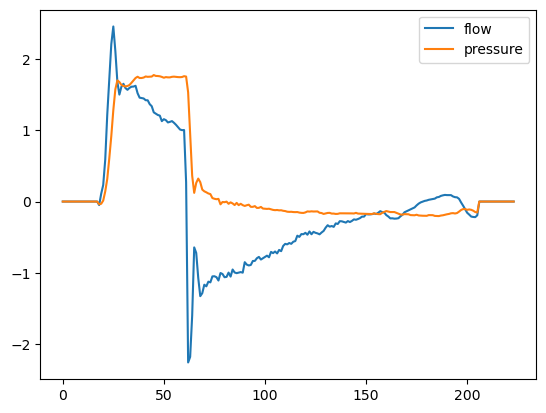

In [11]:
for i, set in enumerate(train_loader):
    data = set[0]
    label = set[1]
    print(np.shape(data))
    print(np.shape(label))

    if i == 3:
        break

plt.plot(data[0, :, 0], label='flow')
plt.plot(data[0, :, 1], label='pressure')
plt.legend()
plt.show()

In [12]:
# Define Parameters
num_epochs = 3
lr = 0.01
hist = copy.deepcopy(history)

In [13]:
model = LSTM(input_size=2, hidden_units=32, num_layers=1, bias=0, output_size=3).cuda()
# You should modify the learning rate as suits the problem
optimizer = SGD(model.parameters(), lr=lr)
bce = nn.BCEWithLogitsLoss()

hist['model'] = 'LSTM'
hist['batch_size'] = batch_size
hist['learning_rate'] = lr
hist['optimizer'] = 'BCE'

In [14]:
def perform_inferencing(model, loader):
    model.cuda()

    predictions = []
    test_labels = []

    model.eval()

    with torch.no_grad():
        for x, y in loader:

            # Load images/labels onto GPU
            x = Variable(x.float()).cuda()
            y = Variable(y.float()).cuda()

            labels = torch.max(y, 1)[1].cpu().numpy()

            output = model(x.float())
            predicted = (torch.max(torch.exp(output), 1))[1].cpu().numpy()
            predictions.extend(predicted)

            test_labels.extend(labels)

    return predictions, test_labels

In [15]:
def validation(model, test_loader, loss_fn):
    model.cuda()
    loss_per_bacth = []

    # Put model into evaluation Mode
    model.eval()

    with torch.no_grad():
        with tqdm(enumerate(test_loader), unit="batch", total=len(test_loader)) as tbatches:
            for i, data in tbatches:
                tbatches.set_description(f"Testing Against Validation:")
                # Load Flow and Pressure Data
                x = data[0]
                # Load Labels
                y = data[1]
                
                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y.float()).cuda()

                outputs = model(x)
                loss = loss_fn(outputs, y)
                loss_per_bacth.append(loss.item())

    return loss_per_bacth

In [16]:
def test_accuracy(model, data_loader):
    model.cuda()
    correct = 0
    total = 0
    accuracy = 0

    # Put model into evaluation Mode
    model.eval()

    with torch.no_grad():
        with tqdm(enumerate(data_loader), unit="batch", total=len(data_loader)) as tbatches:
            for i, data in tbatches:
                tbatches.set_description(f"Testing Accuracy:")
                # Load Flow and Pressure Data
                x = data[0]
                # Load Labels
                y = data[1]

                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y.float()).cuda()

                labels = torch.max(y, 1)[1]
                
                outputs = model(x)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = (100 * correct / total)

    return accuracy

In [17]:
def train(model, loss_fn, optimizer, train_loader, test_loader, num_epochs, history):

    model.cuda()

    # Iterate through all Epochs
    for epoch in range(num_epochs):
        # Init train loss
        train_loss = []

        # Set model to train at the start of every epoch
        model.train()
        with tqdm(enumerate(train_loader), unit="batch", total=len(train_loader)) as tepoch:
            # Iterate through training dataset
            for i, data in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")

                # Load Flow and Pressure Data
                x = data[0]
                # Load Labels
                y = data[1]

                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y.float()).cuda()

                # print(np.shape(x))
                # print(np.shape(y))

                # Zero collected gradients at each step
                optimizer.zero_grad()
                # Forward Propagate
                outputs = model(x)
                # Calculate Loss
                loss = loss_fn(outputs, y)
                # Store Loss
                train_loss.append(loss.item())
                # Back propagate
                loss.backward()
                # Update weights
                optimizer.step()

                # tepoch.set_postfix(training_loss=loss.item())

        # Print statistics on every epoch
        # Calculate validation loss for this epoch
        validation_loss = validation(model=model, test_loader=test_loader, loss_fn=loss_fn)
        # Calculate mean of validation loss
        mean_val_loss = np.mean(validation_loss)
        # Calculate mean of training loss
        mean_train_loss = np.mean(train_loss)
        # Store Validation Loss per epoch
        history['validation_loss'].append(mean_val_loss)
        # Store Training Loss per epoch
        history['training_loss'].append(mean_train_loss)

        # print('Epoch [%d/%d], Step [%d/%d], Training Loss: %.4f, Validation Loss: %.4f'
        #             %(epoch+1, num_epochs, i+1, 
        #             len(train_loader), mean_train_loss,
        #             mean_val_loss))
        
        # Validation Accuracy
        history['validation_accuracy'].append(test_accuracy(model=model, data_loader=test_loader))
        # Training Accuracy
        history['training_accuracy'].append(test_accuracy(model=model, data_loader=train_loader))

        print('Epoch [%d/%d] End, Training Loss: %.4f., Validation Loss: %.4f., Training Accuracy: %.2f %%, Validation Accuracy: %.2f %%'
                            %(epoch+1, num_epochs, 
                            loss.item(), mean_val_loss,
                            history['training_accuracy'][epoch],
                            history['validation_accuracy'][epoch]))
        print('--------------------------------------')
    return history

In [18]:
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(history['training_loss'], label='training loss')
    plt.plot(history['validation_loss'], label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.suptitle('Model: %s, Batch Size: %i, LR: %.4f, Optimizer: %s' %(history['model'], history['batch_size'], history['learning_rate'], history['optimizer']))
    plt.title('Loss vs. Epoch')

    plt.subplot(2, 1, 2)
    plt.plot(history['training_accuracy'], label='training accuracy')
    plt.plot(history['validation_accuracy'], label='validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.suptitle('Model: %s, Batch Size: %i, LR: %.4f, Optimizer: %s' %(history['model'], history['batch_size'], history['learning_rate'], history['optimizer']))
    plt.title('Accuracy vs. Epoch')

    plt.tight_layout()
    plt.show()

In [19]:
# for x, y in train_loader:
#     model.cuda()
#     x = Variable(x.float()).cuda()
#     outputs = model(x)
#     y = Variable(y.float()).cuda()

#     _, outputs_m = (torch.max(torch.exp(outputs), 1))
#     break

In [20]:
# test_dummy = torch.exp(outputs)

In [21]:
# dummy2 = torch.max(y, 1)[1]

In [22]:
# (outputs_m == dummy2).sum().item()

In [23]:
# hx = Variable(x.new_zeros(x.size(0), x.size(1), 32))

# hx = (hx, hx)

# hx, cx = hx

# input_gate, forget_gate, cell_gate, output_gate = hx.chunk(4, 1)

In [24]:
# t_dummy1 = torch.randn(16, 32)
# t_dummy2 = torch.randn(16, 32)

# print(np.shape(t_dummy1 * t_dummy2))
# torch.matmul(t_dummy1, t_dummy2).size()

In [25]:
# Train Network
hist = train(model=model, loss_fn=bce, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, history=hist)

  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [1/3] End, Training Loss: 0.6359., Validation Loss: 0.6255., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [2/3] End, Training Loss: 0.4548., Validation Loss: 0.6103., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [3/3] End, Training Loss: 0.5939., Validation Loss: 0.6081., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


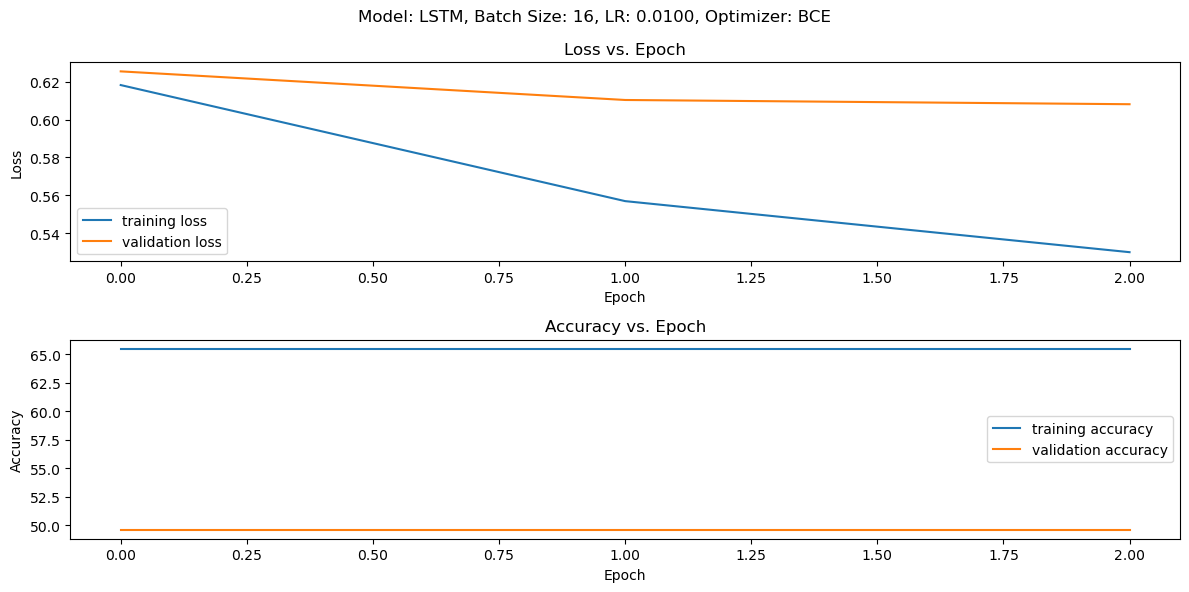

In [26]:
# Plot Learning Curves
plot_learning_curve(hist)

In [27]:
lstm_1, test_labels = perform_inferencing(model=model, loader=test_loader)

cm = confusion_matrix(test_labels, lstm_1, normalize='all')

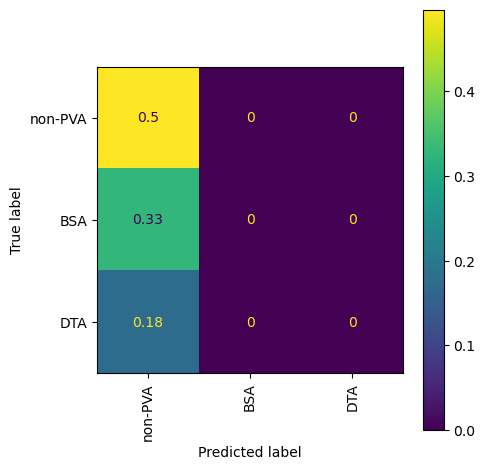

In [28]:
class_names = ['non-PVA', 'BSA', 'DTA']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(include_values=True, xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.show()

In [29]:
# Define Parameters
num_epochs = 3
lr = 0.01
hist = copy.deepcopy(history)

In [30]:
model = LSTM(input_size=2, hidden_units=32, num_layers=3, bias=0, output_size=3).cuda()
# You should modify the learning rate as suits the problem
optimizer = SGD(model.parameters(), lr=lr)
bce = nn.BCEWithLogitsLoss()

hist['model'] = 'LSTM Layer3'
hist['batch_size'] = batch_size
hist['learning_rate'] = lr
hist['optimizer'] = 'BCE'

In [31]:
# Train Network
hist = train(model=model, loss_fn=bce, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, history=hist)

  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [1/3] End, Training Loss: 0.6254., Validation Loss: 0.6298., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [2/3] End, Training Loss: 0.5179., Validation Loss: 0.6122., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


  0%|          | 0/563 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/188 [00:00<?, ?batch/s]

  0%|          | 0/563 [00:00<?, ?batch/s]

Epoch [3/3] End, Training Loss: 0.5202., Validation Loss: 0.6089., Training Accuracy: 65.47 %, Validation Accuracy: 49.60 %
--------------------------------------


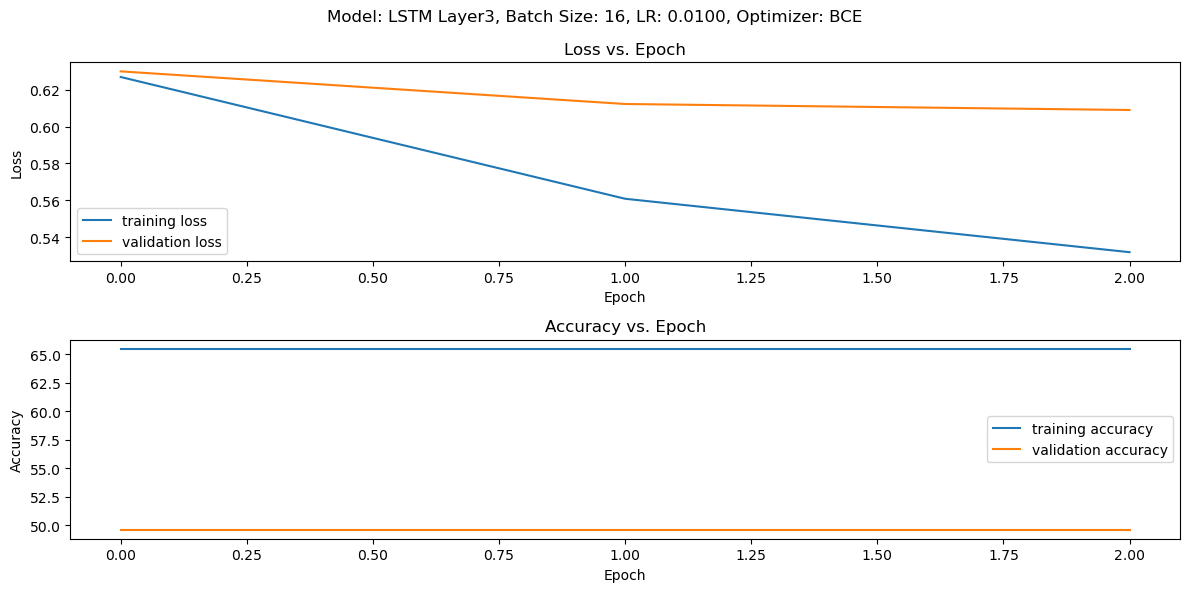

In [32]:
# Plot Learning Curves
plot_learning_curve(hist)

In [33]:
lstm_1, test_labels = perform_inferencing(model=model, loader=test_loader)

cm = confusion_matrix(test_labels, lstm_1, normalize='all')

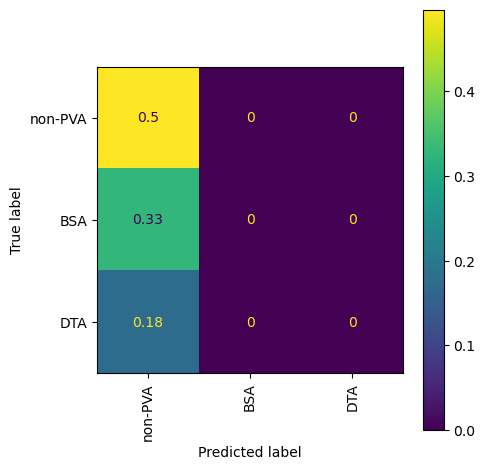

In [34]:
class_names = ['non-PVA', 'BSA', 'DTA']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(include_values=True, xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.show()

## ARDS Detection

Regardless of whether you were successful on your last assignment, the design was to show you the internal mechanism about how LSTM works.

In this assignment you will utilize a dataset of ventilation data taken from 50 subjects. 25 subjects have ARDS, 25 subjects do not have ARDS. Your job is to extract waveform data, and utilize it to perform inferencing on whether the patient has ARDS or not.

1. Use basic CNN architecture to perform classification on whether patient has ARDS or not
2. Add LSTM to CNN architecture, do results improve? if not why? In this assignment you should use the [PyTorch LSTM layer.](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

### Data

The data that we use here is ventilation data but it is structured a bit differently than the PVA dataset. Primarily, the data is structured in continuous breath sequences instead of single breaths. Here is an example.

<img src=ards-data.png width=50% height=auto\>

This has a few advantages: 

1. We don't need padding anymore
2. It improves performance of our model

We stack 20 of these breaths together into a tensor that is in shape `(20, 1, 224)`. This allows us to analyze sequential breaths with an LSTM if we desire. 

In [3]:
from pathlib import Path

from torch.utils.data import DataLoader

from dataset import ARDSDataset

batch_size = 32
num_workers = 4

def get_dataset(path, name):
    saved_set = Path(path)
    # Make sure we save previously processed data. This speeds up future processes.
    if saved_set.exists():
        dataset = ARDSDataset.from_pickle(saved_set.resolve())
    else:
        dataset = ARDSDataset(224, name, to_pickle=saved_set.resolve())
    return dataset
        
        
def get_all_datasets():
    training_set = get_dataset('ards_training_set.pkl', 'train')
    validation_set = get_dataset('ards_validation_set.pkl', 'val')
    testing_set = get_dataset('ards_testing_set.pkl', 'test')
    return training_set, validation_set, testing_set


training_set, validation_set, testing_set = get_all_datasets()
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False, pin_memory=True)

torch.Size([32, 20, 1, 224])
torch.Size([32, 2])
torch.Size([32, 20, 1, 224])
torch.Size([32, 2])
torch.Size([32, 20, 1, 224])
torch.Size([32, 2])
torch.Size([32, 20, 1, 224])
torch.Size([32, 2])


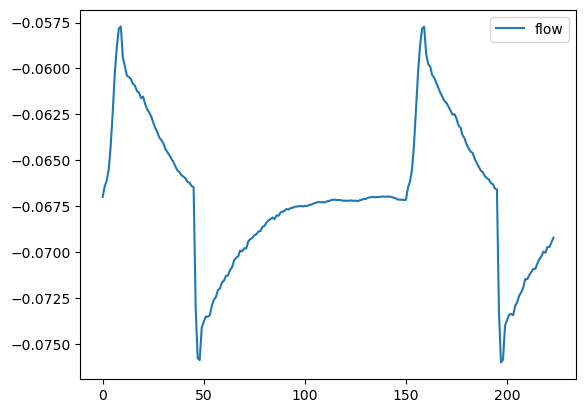

In [4]:
for i, set in enumerate(train_loader):
    pts = set[0]
    data = set[1]
    label = set[2]
    print(np.shape(data))
    print(np.shape(label))

    if i == 3:
        break

plt.plot(data[0, 0, 0, :], label='flow')
plt.legend()
plt.show()

In [5]:
history = {
    'model': str,
    'batch_size': int,
    'learning_rate': float,
    'optimizer': str,
    'training_loss': [],
    'validation_loss': [],
    'training_accuracy': [],
    'validation_accuracy': []
}

In [6]:
from cnn_lstm_net import CNNLSTMNetwork
from densenet import densenet18

In [8]:
def validation(model, test_loader, loss_fn):
    model.cuda()
    loss_per_bacth = []

    # Put model into evaluation Mode
    model.eval()

    with torch.no_grad():
        with tqdm(enumerate(test_loader), unit="batch", total=len(test_loader)) as tbatches:
            for i, data in tbatches:
                tbatches.set_description(f"Testing Against Validation:")
                # Load Flow and Pressure Data
                x = data[1]
                # Load Labels
                y = data[2]
                
                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y.float()).cuda()

                outputs = model(x)
                loss = loss_fn(outputs, y)
                loss_per_bacth.append(loss.item())

    return loss_per_bacth

In [9]:
def test_accuracy(model, data_loader):
    model.cuda()
    correct = 0
    total = 0
    accuracy = 0

    # Put model into evaluation Mode
    model.eval()

    with torch.no_grad():
        with tqdm(enumerate(data_loader), unit="batch", total=len(data_loader)) as tbatches:
            for i, data in tbatches:
                tbatches.set_description(f"Testing Accuracy:")
                # Load Flow and Pressure Data
                x = data[1]
                # Load Labels
                y = data[2]

                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y.float()).cuda()

                labels = torch.max(y, 1)[1]
                
                outputs = model(x)
                _, predicted = torch.max(torch.exp(outputs), 1)
                total += y.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = (100 * correct / total)

    return accuracy

In [10]:
def train(model, loss_fn, optimizer, train_loader, test_loader, num_epochs, history):

    model.cuda()

    # Iterate through all Epochs
    for epoch in range(num_epochs):
        # Init train loss
        train_loss = []

        # Set model to train at the start of every epoch
        model.train()
        with tqdm(enumerate(train_loader), unit="batch", total=len(train_loader)) as tepoch:
            # Iterate through training dataset
            for i, data in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")

                # Load Flow and Pressure Data
                x = data[1]
                # Load Labels
                y = data[2]

                # Load images/labels onto GPU
                x = Variable(x.float()).cuda()
                y = Variable(y).cuda()

                # print(np.shape(x))
                # print(np.shape(y))

                # Zero collected gradients at each step
                optimizer.zero_grad()
                # Forward Propagate
                outputs = model(x)

                # Calculate Loss
                loss = loss_fn(outputs, y)
                # Store Loss
                train_loss.append(loss.item())
                # Back propagate
                loss.backward()
                # Update weights
                optimizer.step()

                # tepoch.set_postfix(training_loss=loss.item())

        # Print statistics on every epoch
        # Calculate validation loss for this epoch
        validation_loss = validation(model=model, test_loader=test_loader, loss_fn=loss_fn)
        # Calculate mean of validation loss
        mean_val_loss = np.mean(validation_loss)
        # Calculate mean of training loss
        mean_train_loss = np.mean(train_loss)
        # Store Validation Loss per epoch
        history['validation_loss'].append(mean_val_loss)
        # Store Training Loss per epoch
        history['training_loss'].append(mean_train_loss)

        # print('Epoch [%d/%d], Step [%d/%d], Training Loss: %.4f, Validation Loss: %.4f'
        #             %(epoch+1, num_epochs, i+1, 
        #             len(train_loader), mean_train_loss,
        #             mean_val_loss))
        
        # Validation Accuracy
        history['validation_accuracy'].append(test_accuracy(model=model, data_loader=test_loader))
        # Training Accuracy
        history['training_accuracy'].append(test_accuracy(model=model, data_loader=train_loader))

        print('Epoch [%d/%d] End, Training Loss: %.4f., Validation Loss: %.4f., Training Accuracy: %.2f %%, Validation Accuracy: %.2f %%'
                            %(epoch+1, num_epochs, 
                            loss.item(), mean_val_loss,
                            history['training_accuracy'][epoch],
                            history['validation_accuracy'][epoch]))
        print('--------------------------------------')
    return history

In [11]:
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(history['training_loss'], label='training loss')
    plt.plot(history['validation_loss'], label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.suptitle('Model: %s, Batch Size: %i, LR: %.4f, Optimizer: %s' %(history['model'], history['batch_size'], history['learning_rate'], history['optimizer']))
    plt.title('Loss vs. Epoch')

    plt.subplot(2, 1, 2)
    plt.plot(history['training_accuracy'], label='training accuracy')
    plt.plot(history['validation_accuracy'], label='validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # plt.suptitle('Model: %s, Batch Size: %i, LR: %.4f, Optimizer: %s' %(history['model'], history['batch_size'], history['learning_rate'], history['optimizer']))
    plt.title('Accuracy vs. Epoch')

    plt.tight_layout()
    plt.show()

In [12]:
def perform_inferencing(model, loader):
    model.cuda()

    patient_list = {}

    model.eval()

    with torch.no_grad():
        for pt, x, y in loader:

            # Load images/labels onto GPU
            x = Variable(x.float()).cuda()
            y = Variable(y.float()).cuda()

            labels = torch.max(y, 1)[1].cpu().numpy()

            output = model(x.float())
            predicted = (torch.max(torch.exp(output), 1))[1].cpu().numpy()

            for batch_idx, batch_patient in enumerate(pt):

                if batch_patient not in patient_list.keys():
                    patient_list[batch_patient] = {'labels': [], 'predictions': []}

                patient_prediction = predicted[batch_idx]
                patient_label = labels[batch_idx]

                patient_list[batch_patient]['predictions'].append(patient_prediction)
                patient_list[batch_patient]['labels'].append(patient_label)

    return patient_list

In [13]:
dummy = {}
prediction = [1, 1, 0, 1, 0]
dummy['8856'] = {'labels': [], 'predictions': []}

dummy['8856']['labels'].append(42)

dummy['8856']['labels'].append(5)

dummy['8856']['labels']

[42, 5]

### CNN

In [14]:
class CNNNetwork(nn.Module):
    def __init__(self, cnn_network, num_classes):
        super(CNNNetwork, self).__init__()
        
        self.cnn = cnn_network
        self.output_size = num_classes
        self.input_size = 128 # input_size derived from size of cnn `outputs`
    
        self.fc = nn.Linear(self.input_size, self.output_size)

    def forward(self, x):
        batch_size = x.shape[0]
        
        # input should be in shape: (batches, breaths in seq, chans, 224)
        batches = batch_size
        outputs = self.cnn(x[0]).squeeze()
        outputs = outputs.unsqueeze(dim=0)

        
        for i in range(1, batches):
            block_out = self.cnn(x[i]).squeeze()
            block_out = block_out.unsqueeze(dim=0)
            outputs = torch.cat([outputs, block_out], dim=0)

        output = self.fc(outputs)

        output = torch.sum(output, 1) / output.size(1)

        return output

In [15]:
# You are welcome to evaluate other CNN backbones
cnn = densenet18()

# feel free to modify these parameters
num_classes = 2

model = CNNNetwork(cnn, num_classes)

lr  = 0.001
num_epochs = 3

# We highly recommend using SGD for this problem
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
bce = nn.BCEWithLogitsLoss()

In [16]:
hist = copy.deepcopy(history)
hist['model'] = 'CNN'
hist['batch_size'] = batch_size
hist['learning_rate'] = lr
hist['optimizer'] = 'BCE'

In [17]:
# Train Network
hist = train(model=model, loss_fn=bce, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, history=hist)

  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [1/3] End, Training Loss: 0.6796., Validation Loss: 0.6956., Training Accuracy: 64.52 %, Validation Accuracy: 50.95 %
--------------------------------------


  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [2/3] End, Training Loss: 0.6643., Validation Loss: 0.6846., Training Accuracy: 60.08 %, Validation Accuracy: 75.63 %
--------------------------------------


  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [3/3] End, Training Loss: 0.6812., Validation Loss: 0.6884., Training Accuracy: 61.34 %, Validation Accuracy: 66.47 %
--------------------------------------


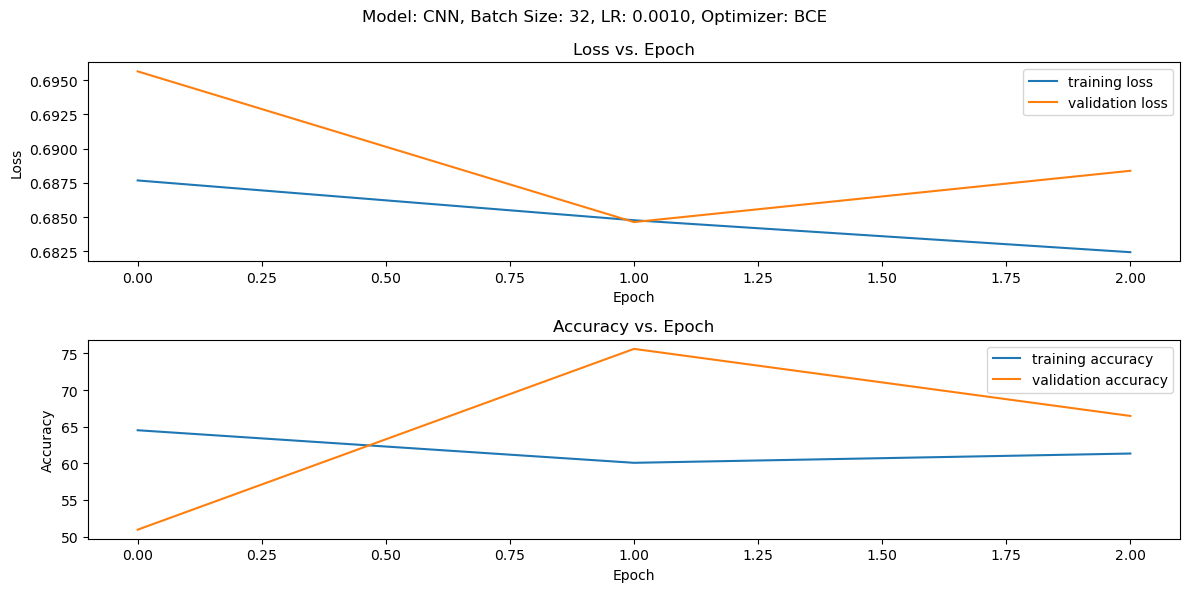

In [18]:
# Plot Learning Curves
plot_learning_curve(hist)

In [19]:
patient_list = perform_inferencing(model=model, loader=test_loader)

# cm = confusion_matrix(test_labels, lstm_1, normalize='all')

In [20]:
patient_list.keys()

dict_keys(['1229', '1602', '2083', '243', '5454', '6179', '6479', '7441', '7624', '9623'])

In [ ]:
class_names = ['non-PVA', 'BSA', 'DTA']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(include_values=True, xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.show()

### LSTM + CNN

In [5]:
# You are welcome to evaluate other CNN backbones
cnn = densenet18()

# feel free to modify these parameters
lstm_hidden_units = 128
lstm_layers = 1

# 0 means there is 0% probability of dropout happening
lstm_dropout = 0

model = CNNLSTMNetwork(cnn, lstm_hidden_units, lstm_layers, lstm_dropout)

lr  = 0.001
num_epochs = 3

# We highly recommend using SGD for this problem
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
bce = nn.BCEWithLogitsLoss()

In [7]:
hist = copy.deepcopy(history)
hist['model'] = 'LSTM + CNN'
hist['batch_size'] = batch_size
hist['learning_rate'] = lr
hist['optimizer'] = 'BCE'

In [12]:
# Train Network
hist = train(model=model, loss_fn=bce, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, history=hist)

  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [1/3] End, Training Loss: 0.6779., Validation Loss: 0.6825., Training Accuracy: 54.13 %, Validation Accuracy: 58.36 %
--------------------------------------


  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [2/3] End, Training Loss: 0.6843., Validation Loss: 0.6800., Training Accuracy: 54.13 %, Validation Accuracy: 58.36 %
--------------------------------------


  0%|          | 0/469 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/183 [00:00<?, ?batch/s]

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch [3/3] End, Training Loss: 0.7056., Validation Loss: 0.6808., Training Accuracy: 54.13 %, Validation Accuracy: 58.36 %
--------------------------------------


In [13]:
dummy = torch.randn((32, 20, 1, 128))

In [14]:
torch.zeros((dummy.size(0), 128)).size()

torch.Size([32, 128])

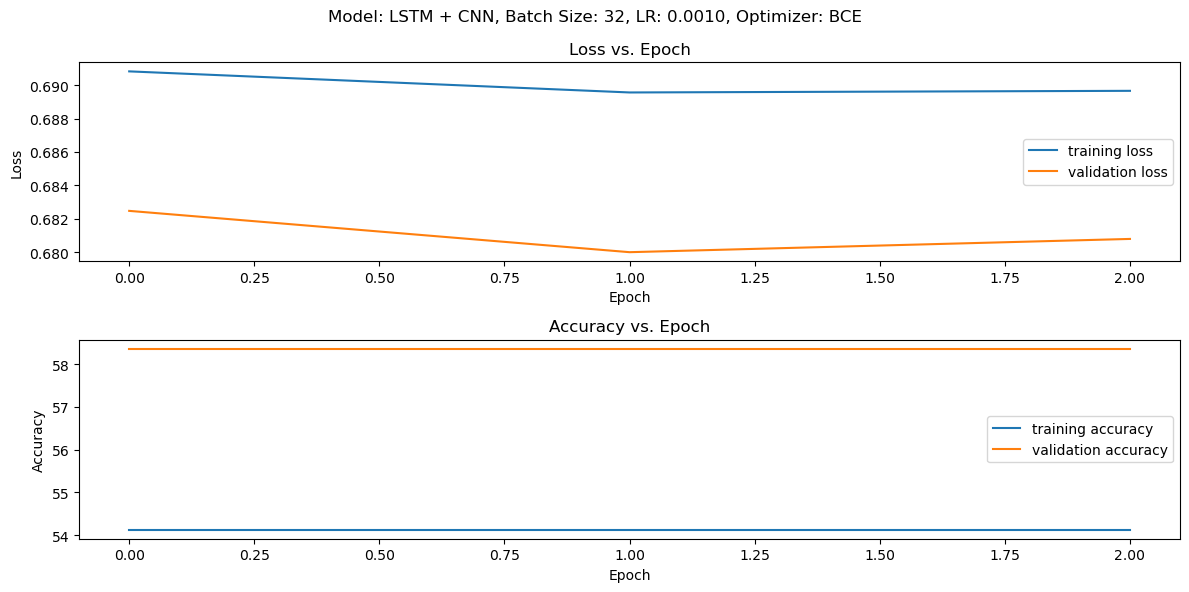

In [16]:
# Plot Learning Curves
plot_learning_curve(hist)

In [17]:
total = 0
correct = 0
accuracy = 0

dummy = model(data.float().cuda())
dummy2 = torch.argmax(label, dim=1)
dummy3 = torch.max(label, 1)[1]
_, predicted = torch.max((dummy), 1)
total += label.size(0)
correct += (predicted == dummy2.cuda()).sum().item()
accuracy = (100 * correct / total)